# Machine Learning for String Field Theory

*H. Erbin, R. Finotello, M. Kudrna, M. Schnabl*

## Abstract

In the framework of bosonic **Open String Field Theory** (OSFT), we consider several observables characterised by conformal weight, periodicity of the oscillations and the position of vacua in the potential for various values of truncated mass level.
We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

## Synopsis

In this notebook we train the machine learning algorithms on the lumps dataset.
We use a recurrent neural network with LSTM cells to predict the infinite level extrapolation from finite level data.

## General Observations

The idea is to improve the finite level predictions and reaching a result as close as possible to the extrapolated label.
In general we can first rescale all the labels to be in the interval $[-1, 1]$ (the lumps should already be in that interval).
We need to find a strategy to evaluate the extrapolated labels with respect to the finite level truncation.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import joblib
import time
from IPython.display import Image
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from tensorflow import keras
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from analysis import *

import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

# set matplot
sns.set()
PREFIX = 'lumps_'
SUFFIX = '_lstm_embedding'

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# set random seed
RAND = 123
np.random.seed(RAND)
tf.random.set_seed(RAND)

In [2]:
# create shortcuts for paths
proot = lambda s: os.path.join('.', s)
pdata = lambda s: os.path.join(proot('data'), s)
pimg  = lambda s: os.path.join(proot('img'), s)
pmet  = lambda s: os.path.join(proot('metrics'), s)
pmod  = lambda s: os.path.join(proot('models'), s)

## Load the Dataset

In [3]:
df = pd.read_csv(pdata('lumps.csv'))
last = 'level_18'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   solution  718 non-null    int64  
 1   weight    718 non-null    float64
 2   type_2    718 non-null    int64  
 3   type_4    718 non-null    int64  
 4   level_2   718 non-null    float64
 5   level_3   718 non-null    float64
 6   level_4   718 non-null    float64
 7   level_5   718 non-null    float64
 8   level_6   718 non-null    float64
 9   level_7   718 non-null    float64
 10  level_8   718 non-null    float64
 11  level_9   718 non-null    float64
 12  level_10  718 non-null    float64
 13  level_11  718 non-null    float64
 14  level_12  718 non-null    float64
 15  level_13  718 non-null    float64
 16  level_14  718 non-null    float64
 17  level_15  718 non-null    float64
 18  level_16  718 non-null    float64
 19  level_17  718 non-null    float64
 20  level_18  718 non-null    float6

We need to:

1. define the evaluation metrics,
2. divide into training and test sets,
3. train the algorithms,
4. evaluate each algorithm.

## Evaluation Metric

In general we use the average ratio between the residuals of predicted level and the last finite truncation level:
\begin{equation}
    R(y_{true}, y_{finite}, y_{pred}) = \frac{1}{N} \sum\limits_{i = 1}^N \log_{10}\left| \frac{y_{true}^{(i)} - y_{pred}^{(i)}}{y_{true}^{(i)} - y_{finite}^{(i)}} \right|
\end{equation}
This way a negative result would represent an improvement on finite truncation levels.

## Train and Test Sets

In [4]:
train, test = train_test_split(df, train_size=0.9, shuffle=True, random_state=RAND)

X_train = train.filter(regex='solution|weight|type.*|level_.*')
X_train.to_csv(pdata(PREFIX + 'X_train' + SUFFIX + '.csv'), index=False)
X_train = X_train.drop(columns=['solution', 'weight', 'type_2', 'type_4']).values

X_test  = test.filter(regex='solution|weight|type.*|level_.*')
X_test.to_csv(pdata(PREFIX + 'X_test' + SUFFIX + '.csv'), index=False)
X_test = X_test.drop(columns=['solution', 'weight', 'type_2', 'type_4']).values

y_train = train['exp']
y_train.to_csv(pdata(PREFIX + 'y_train' + SUFFIX + '.csv'), index=False)
y_train = y_train.values.reshape(-1,)

y_test  = test['exp']
y_test.to_csv(pdata(PREFIX + 'y_test' + SUFFIX + '.csv'), index=False)
y_test = y_test.values.reshape(-1,)

In [5]:
print(f'Shape of the full training set: X = {X_train.shape}, y = {y_train.shape}')
print(f'Shape of the test          set: X = {X_test.shape},  y = {y_test.shape}')

Shape of the full training set: X = (646, 17), y = (646,)
Shape of the test          set: X = (72, 17),  y = (72,)


We also need a validation set (10% of the samples) for the neural networks:

In [6]:
train, validation = train_test_split(train, test_size=1/9, shuffle=True, random_state=RAND)

X_train_nn = train.filter(regex='solution|weight|type.*|level_.*')
X_train_nn.to_csv(pdata(PREFIX + 'X_train_nn' + SUFFIX + '.csv'), index=False)
X_train_nn = X_train_nn.drop(columns=['solution', 'weight', 'type_2', 'type_4']).values

X_val_nn  = validation.filter(regex='solution|weight|type.*|level_.*')
X_val_nn.to_csv(pdata(PREFIX + 'X_val_nn' + SUFFIX + '.csv'), index=False)
X_val_nn = X_val_nn.drop(columns=['solution', 'weight', 'type_2', 'type_4']).values

y_train_nn = train['exp']
y_train_nn.to_csv(pdata(PREFIX + 'y_train_nn' + SUFFIX + '.csv'), index=False)
y_train_nn = y_train_nn.values.reshape(-1,)

y_val_nn  = validation['exp']
y_val_nn.to_csv(pdata(PREFIX + 'y_val_nn' + SUFFIX + '.csv'), index=False)
y_val_nn = y_val_nn.values.reshape(-1,)

y_test_nn = y_test

In [7]:
print(f'Shape of the training   set (ANN): X = {X_train_nn.shape}, y = {y_train_nn.shape}')
print(f'Shape of the validation set (ANN): X = {X_val_nn.shape},  y = {y_val_nn.shape}')

Shape of the training   set (ANN): X = (574, 17), y = (574,)
Shape of the validation set (ANN): X = (72, 17),  y = (72,)


## Extract the Last Truncation Level

In [8]:
last_train    = X_train[:,-1].reshape(-1,)
last_train_nn = X_train_nn[:,-1].reshape(-1,)
last_val_nn   = X_val_nn[:,-1].reshape(-1,)
last_test     = X_test[:,-1].reshape(-1,)
last_test_nn  = X_test[:,-1].reshape(-1,)

## Rescale the Truncation Levels

In [9]:
lev_scaler    = StandardScaler()
lev_scaler_nn = StandardScaler()

# scale the cross-validation levels
X_train = lev_scaler.fit_transform(X_train)
X_test  = lev_scaler.transform(X_test)

# scale the neural network labels
X_train_nn = lev_scaler_nn.fit_transform(X_train_nn)
X_val_nn   = lev_scaler_nn.transform(X_val_nn)
X_test_nn  = lev_scaler_nn.transform(X_test)

In [10]:
os.makedirs('./models', exist_ok=True)

In [11]:
# save the scalers
joblib.dump(lev_scaler, pmod(PREFIX + 'levels_cv_scaler' + SUFFIX + '.pkl'))
joblib.dump(lev_scaler_nn, pmod(PREFIX + 'levels_nn_scaler' + SUFFIX + '.pkl'))

['./models/lumps_levels_nn_scaler_lstm_embedding.pkl']

## Training

In [12]:
os.makedirs('./img', exist_ok=True)
os.makedirs('./metrics', exist_ok=True)

In [13]:
LATENT_DIM = 100

### Artificial Neural Network (w/ Keras)

In [14]:
keras.backend.clear_session()

ann = keras.models.Sequential([keras.layers.Input(shape=X_train_nn.shape[1:], name='input'),
                               #####################################################################
                               keras.layers.Dense(LATENT_DIM,
                                                  activation='relu',
                                                  kernel_regularizer=keras.regularizers.l2(1.0e-2)
                                                 ),
                               keras.layers.Dropout(0.2),
                               #####################################################################
                               keras.layers.Dense(LATENT_DIM,
                                                  activation='relu',
                                                  kernel_regularizer=keras.regularizers.l2(1.0e-2)
                                                 ),
                               keras.layers.Dropout(0.2),
                               #####################################################################
                               keras.layers.Dense(LATENT_DIM,
                                                  activation='relu',
                                                  kernel_regularizer=keras.regularizers.l2(1.0e-2)
                                                 ),
                               keras.layers.Dropout(0.2),
                               #####################################################################
                               keras.layers.Reshape((LATENT_DIM, 1)),
                               #####################################################################
                               keras.layers.Bidirectional(
                                   keras.layers.LSTM(50,
                                                     return_sequences=True,
                                                     kernel_regularizer=keras.regularizers.l2(1.0e-2)
                                                    )
                               ),
                               keras.layers.Dropout(0.2),
                               #####################################################################
                               keras.layers.Bidirectional(
                                   keras.layers.LSTM(30,
                                                     return_sequences=True,
                                                     kernel_regularizer=keras.regularizers.l2(1.0e-2)
                                                    )
                               ),
                               keras.layers.Dropout(0.2),
                               #####################################################################
                               keras.layers.Bidirectional(
                                   keras.layers.LSTM(30,
                                                     return_sequences=True,
                                                     kernel_regularizer=keras.regularizers.l2(1.0e-2)
                                                    )
                               ),
                               keras.layers.Dropout(0.1),
                               #####################################################################
                               keras.layers.Bidirectional(
                                   keras.layers.LSTM(10,
                                                     kernel_regularizer=keras.regularizers.l2(1.0e-2)
                                                    )
                               ),
                               keras.layers.Dropout(0.1),
                               #####################################################################
                               keras.layers.Dense(1, name='exp')
                              ],
                              name='lumps'
                             )
ann.compile(optimizer=keras.optimizers.Adam(learning_rate=1.0e-3),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()]
           )
ann.summary()

Model: "lumps"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1800      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
reshape (Reshape)            (None, 100, 1)            0     

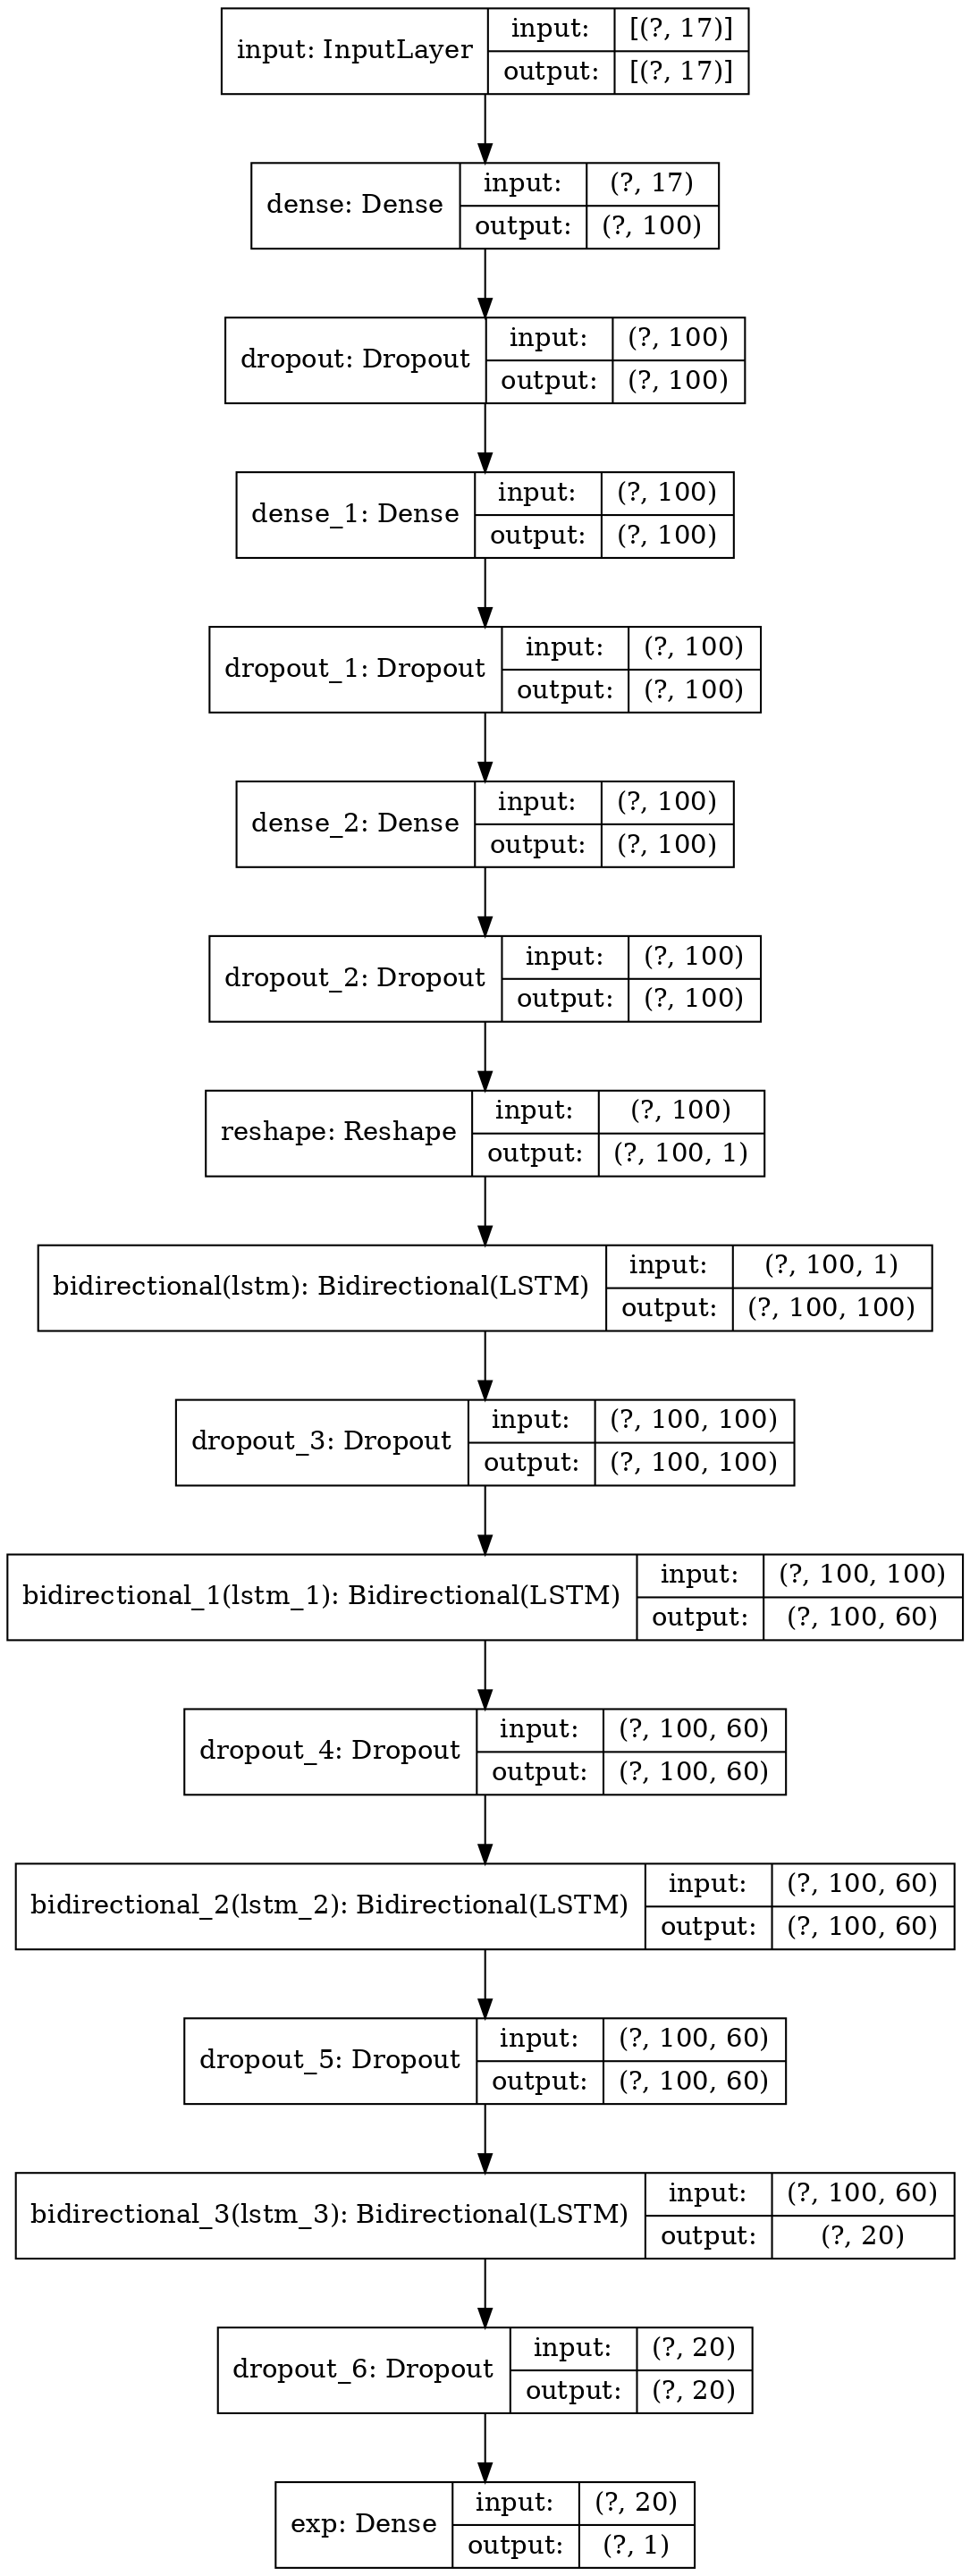

In [15]:
# save figure
ann_dot = keras.utils.model_to_dot(ann,
                                   #rankdir='LR',
                                   rankdir='TB',
                                   show_shapes=True,
                                   dpi=150)
ann_dot.write_pdf(pimg(PREFIX + 'ann_arch' + SUFFIX + '.pdf'))
Image(ann_dot.create_png(), width=320)

In [16]:
def lr_scheduler(epoch, lr):
    '''
    Schedule the learning rate:
    
    Arguments:
        epoch: the current epoch,
        lr:    the current learning rate.
    '''
    if epoch < 1000:
        return lr
    else:
        if lr <= 1.0e-7:
            return lr
        else:
            return lr * tf.math.exp(-1.0e-3)

In [17]:
t = time.time()
ann_history = ann.fit(x=X_train_nn,
                      y=y_train_nn,
                      batch_size=32,
                      epochs=20000,
                      verbose=0,
                      callbacks=[keras.callbacks.EarlyStopping(patience=2500, restore_best_weights=True, verbose=0),
                                 keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0),
                                 keras.callbacks.ModelCheckpoint(pmod(PREFIX + 'ann' + SUFFIX + '.h5'), verbose=0, save_best_only=True)
                                ],
                      validation_data=(X_val_nn, y_val_nn)
                     )
t = time.time() - t
print(f'Training took {t:.3f} seconds.')

Training took 1639.457 seconds.


In [18]:
# save and display history
ann_history_obj = pd.DataFrame(ann_history.history)
ann_history_obj.to_csv(pmod(PREFIX + 'ann_history' + SUFFIX + '.csv'), index=False)
print(f'No. of epochs: {ann_history_obj.shape[0]:d}')

No. of epochs: 2712


In [19]:
history_plots(ann_history_obj, prefix=PREFIX, suffix=SUFFIX)

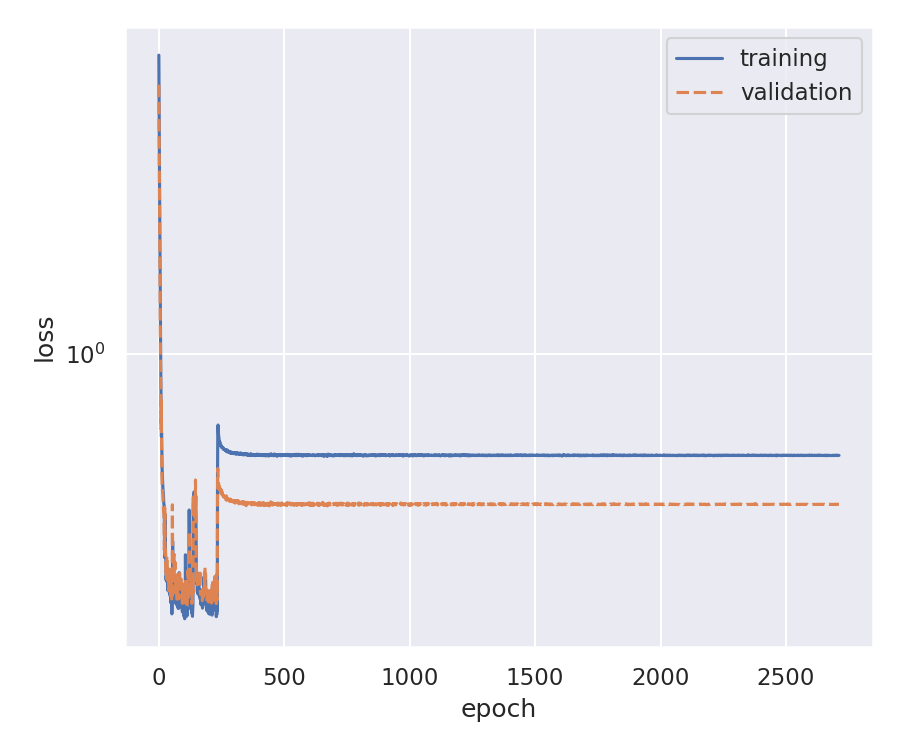

In [20]:
Image(pimg(PREFIX + 'ann_loss' + SUFFIX + '.png'), width=480)

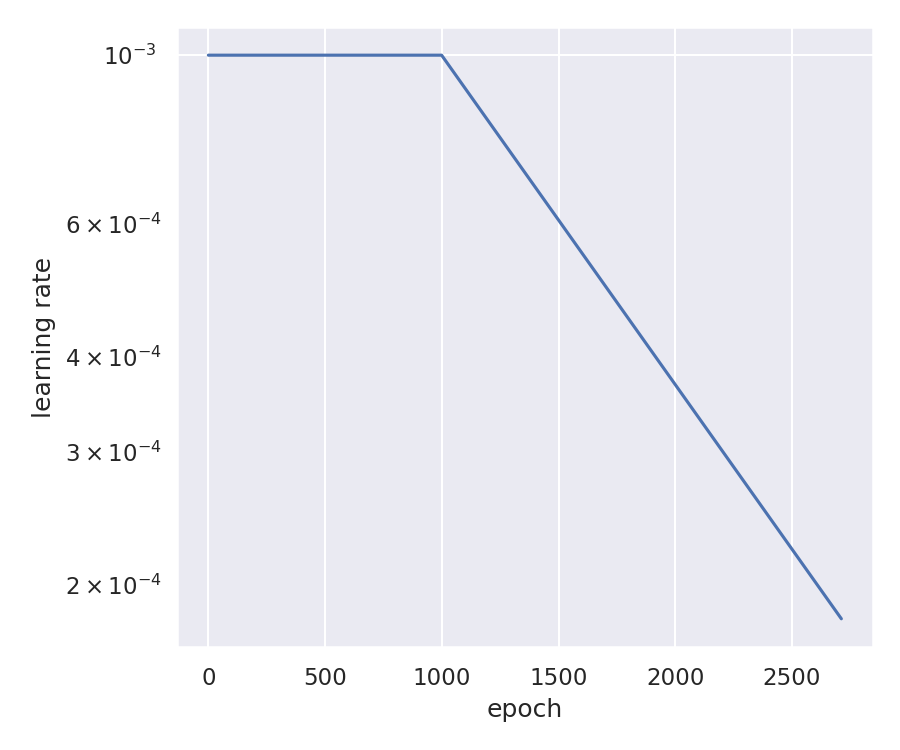

In [21]:
Image(pimg(PREFIX + 'ann_lr' + SUFFIX + '.png'), width=480)

In [22]:
train_metrics = make_predictions(ann, X_train_nn, y_train_nn, last_train_nn, prefix=PREFIX, suffix=SUFFIX, name='train_ann', tensor=True)
val_metrics   = make_predictions(ann, X_val_nn, y_val_nn, last_val_nn, prefix=PREFIX, suffix=SUFFIX, name='val_ann', tensor=True)
test_metrics  = make_predictions(ann, X_test_nn, y_test_nn, last_test_nn, prefix=PREFIX, suffix=SUFFIX, name='test_ann', tensor=True)

# concatenate the prediction results
metrics = pd.concat([train_metrics, val_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet(PREFIX + 'ann_metrics' + SUFFIX + '.csv'))
metrics

,train_ann,val_ann,test_ann
mean_squared_error,0.125101,0.158660,0.469083
mean_absolute_error,0.252938,0.277185,0.459741
r2_score,0.761694,0.570725,-0.180450
residual_ratio,-0.901473,-0.301662,-0.391021


In [23]:
make_plots(ann, X_train_nn, y_train_nn, last_train_nn, prefix=PREFIX, suffix=SUFFIX, name='train_ann')
make_plots(ann, X_val_nn, y_val_nn, last_val_nn, prefix=PREFIX, suffix=SUFFIX, name='val_ann')
make_plots(ann, X_test_nn, y_test_nn, last_test_nn, prefix=PREFIX, suffix=SUFFIX, name='test_ann')
compare_plots_val(ann,
                  X_train_nn, y_train_nn, last_train_nn,
                  X_val_nn, y_val_nn, last_val_nn,
                  X_test_nn, y_test_nn, last_test_nn,
                  legend=['training', 'validation', 'test'],
                  prefix=PREFIX,
                  suffix=SUFFIX,
                  name='ann'
                 )

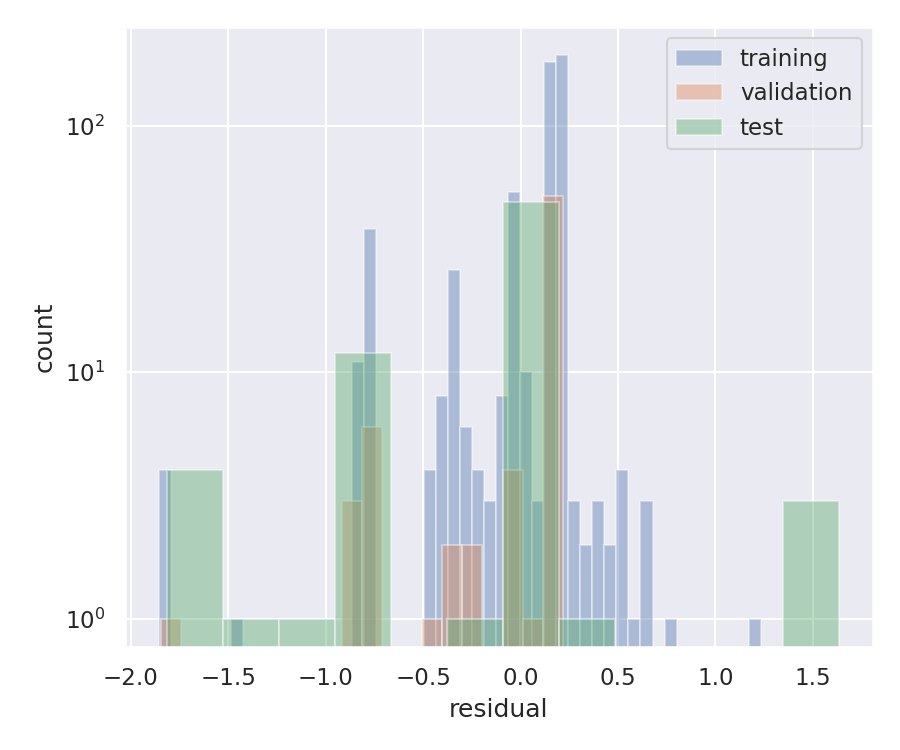

In [24]:
Image(pimg(PREFIX + 'ann_residual_histogram_compare' + SUFFIX + '.png'), width=480)

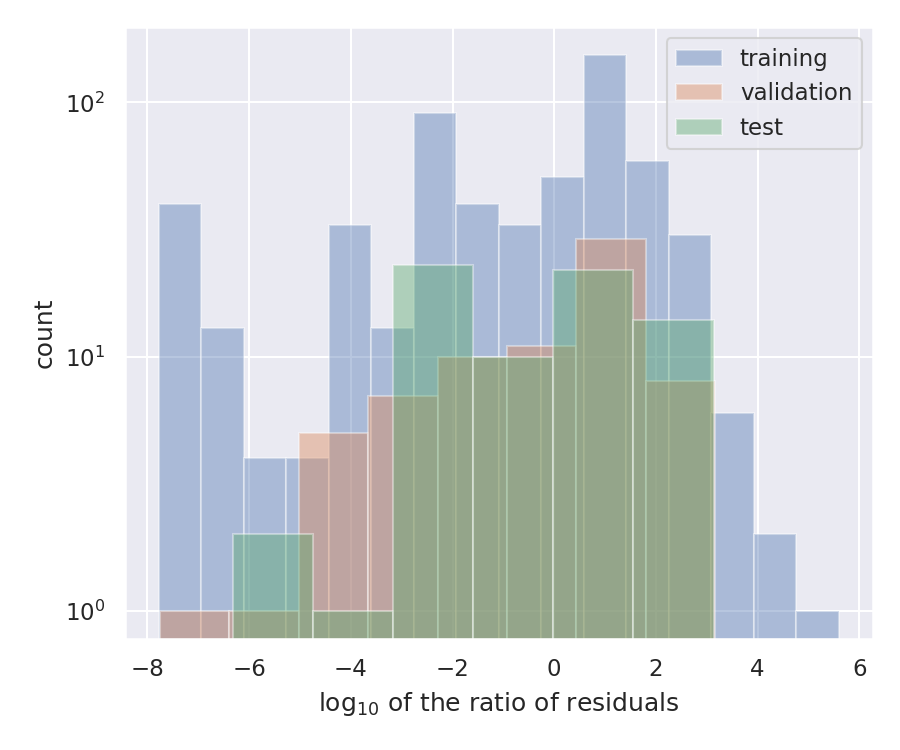

In [25]:
Image(pimg(PREFIX + 'ann_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

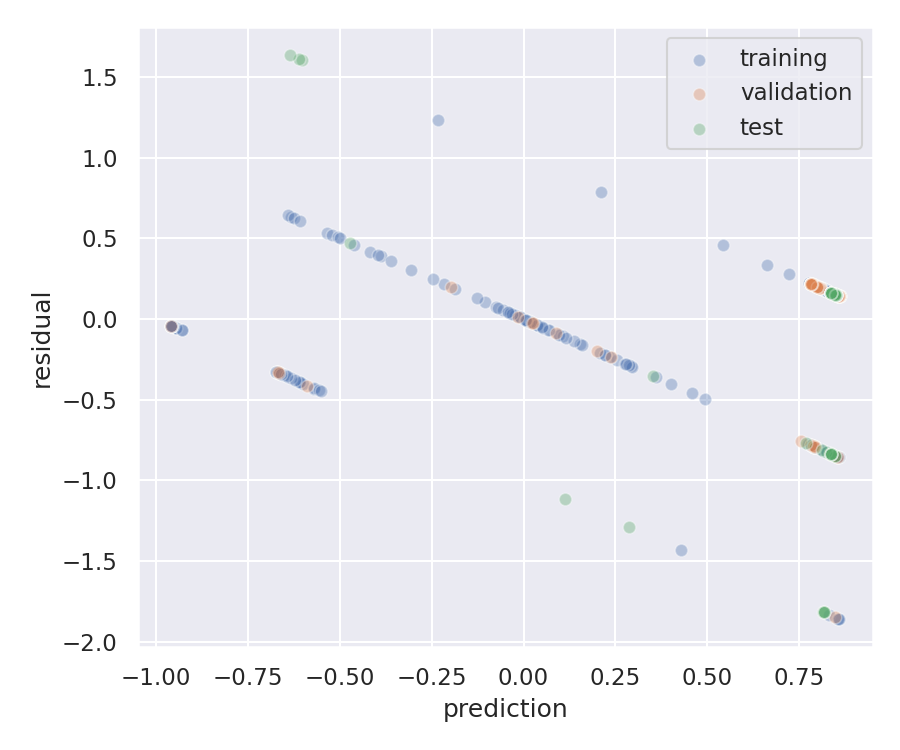

In [26]:
Image(pimg(PREFIX + 'ann_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

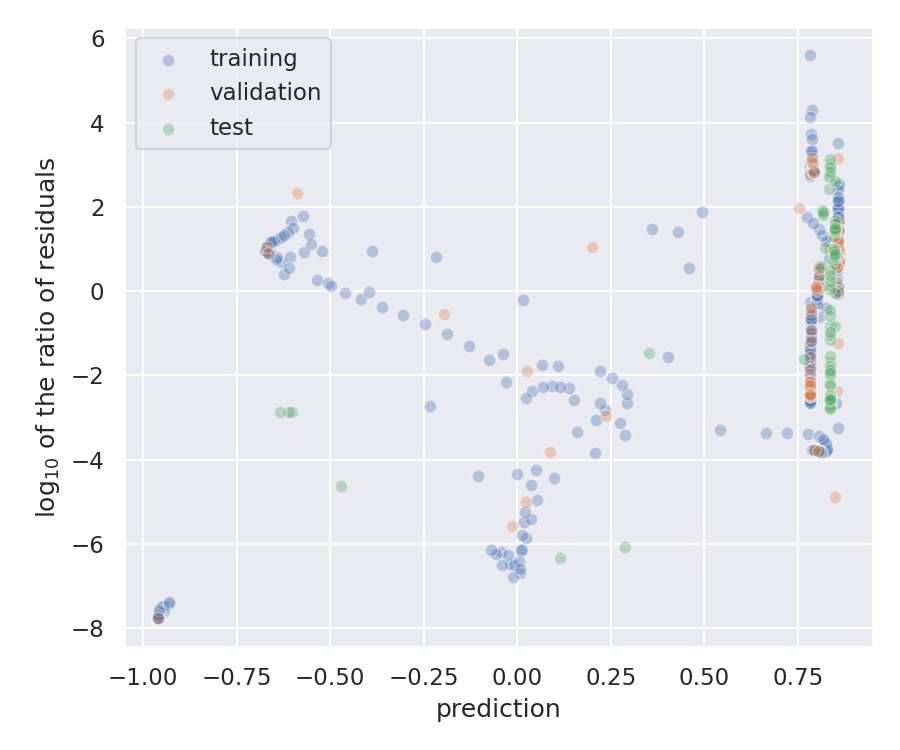

In [27]:
Image(pimg(PREFIX + 'ann_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

## Double Lumps

We finally show how the various algorithms can generalise to double lump solutions.
We keep only weight $h \le 1.25$.

In [28]:
dlumps = pd.read_csv(pdata('dlumps.csv'))
dlumps = dlumps.loc[dlumps['weight'] <= 1.25]
dlumps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 11
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   weight    10 non-null     float64
 1   type_2    10 non-null     int64  
 2   type_4    10 non-null     int64  
 3   level_2   10 non-null     float64
 4   level_3   10 non-null     float64
 5   level_4   10 non-null     float64
 6   level_5   10 non-null     float64
 7   level_6   10 non-null     float64
 8   level_7   10 non-null     float64
 9   level_8   10 non-null     float64
 10  level_9   10 non-null     float64
 11  level_10  10 non-null     float64
 12  level_11  10 non-null     float64
 13  level_12  10 non-null     float64
 14  level_13  10 non-null     float64
 15  level_14  10 non-null     float64
 16  level_15  10 non-null     float64
 17  level_16  10 non-null     float64
 18  level_17  10 non-null     float64
 19  level_18  10 non-null     float64
 20  exp       10 non-null     float64


# Extract the Labels

In [29]:
# extract the labels
y_dlumps    = dlumps['exp'].values.reshape(-1,)
y_dlumps_nn = dlumps['exp'].values.reshape(-1,)

## Extract the Levels

In [30]:
# extract the features
X_dlumps = dlumps.drop(columns=['weight', 'type_2', 'type_4', 'exp']).values

## Rescale the Features

In [31]:
lev_scaler    = joblib.load(pmod(PREFIX + 'levels_cv_scaler' + SUFFIX + '.pkl'))
lev_scaler_nn = joblib.load(pmod(PREFIX + 'levels_cv_scaler' + SUFFIX + '.pkl'))

# rescale the levels
X_dlumps    = lev_scaler.transform(X_dlumps)
X_dlumps_nn = lev_scaler_nn.transform(X_dlumps)

## Compute Predictions

In [32]:
predictions = {'real_values': dlumps['exp'].values.reshape(-1,),
               'finite_values': dlumps['level_18'].values.reshape(-1,)
              }

# ANN
ann = keras.models.load_model(pmod(PREFIX + 'ann' + SUFFIX + '.h5'))
predictions['lstm'] = 2 * ann.predict(X_dlumps_nn).reshape(-1,1).reshape(-1,)

# get dataframe
predictions = pd.DataFrame(predictions)
predictions.to_csv(pdata(PREFIX + 'dlumps_predictions' + SUFFIX + '.csv'), index=False)
predictions

,real_values,finite_values,lstm
0,2.000132,2.010872,1.706896
1,-0.000045,0.000039,1.663526
2,-2.000161,-2.048203,1.267991
3,1.998589,2.008174,1.706723
4,0.955293,0.875055,1.681172
5,-1.083093,-1.174038,1.581908
6,-1.994476,-1.952275,1.486776
7,-0.827465,-0.573408,1.663199
8,1.213654,1.409107,1.698406
9,2.015004,1.585226,1.663914


In [33]:
metrics = {'mean_squared_error': mean_squared_error(predictions['real_values'],
                                                    predictions['lstm']
                                                   ),
           'mean_absolute_error': mean_absolute_error(predictions['real_values'],
                                                      predictions['lstm']
                                                     ),
           'r2_score': r2_score(predictions['real_values'],
                                predictions['lstm']
                               ),
           'residual_ratio': metric(predictions['real_values'],
                                    dlumps['level_18'].values.reshape(-1,),
                                    predictions['lstm']
                                   )
          }

# get dataframe
metrics = pd.DataFrame(metrics, index=['lstm'])
metrics.to_csv(pmet(PREFIX + 'dlumps_metrics' + SUFFIX + '.csv'))
metrics

,mean_squared_error,mean_absolute_error,r2_score,residual_ratio
lstm,3.992936,1.571546,-0.680644,1.474396


In [34]:
# compute residual and residual ratio per value
residuals = {'lstm_res': predictions['real_values'].values.reshape(-1,) - predictions['lstm'].values.reshape(-1,)}
ratios    = {'lstm_ratio': np.log10(
                             np.abs(
                                np.divide(predictions['real_values'].values.reshape(-1,) - predictions['lstm'].values.reshape(-1,),
                                          predictions['real_values'].values.reshape(-1,) - predictions['finite_values'].values.reshape(-1,)
                                         )
                                )
                            )
            }

# get dataframe
residuals = pd.DataFrame(residuals)
ratios    = pd.DataFrame(ratios)
metric_per_value = pd.concat([residuals, ratios], axis=1)
metric_per_value.to_csv(pmet(PREFIX + 'dlumps_metric_per_value' + SUFFIX + '.csv'), index=False)
metric_per_value

,lstm_res,lstm_ratio
0,0.293236,1.436216
1,-1.663571,4.297664
2,-3.268152,1.832681
3,0.291865,1.483576
4,-0.725879,0.956481
5,-2.665002,1.466920
6,-3.481252,1.916417
7,-2.490664,0.991385
8,-0.484752,0.394479
9,0.351090,-0.087826
